In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

plt.style.use("seaborn-v0_8")


In [2]:
data = pd.read_csv("../data/processed/ethiopia_fi_enriched.csv")
observations = data[data["record_type"] == "observation"].copy()


In [3]:
# Access
access = observations[
    observations["indicator_code"] == "ACC_OWNERSHIP"
].sort_values("observation_date")

access["year"] = pd.to_datetime(access["observation_date"]).dt.year

# Usage proxy (Digital payments proxy)
usage = observations[
    observations["indicator_code"] == "ACC_MM_ACCOUNT"
].sort_values("observation_date")

usage["year"] = pd.to_datetime(usage["observation_date"]).dt.year


Two forecasting targets are defined:

Access: Percentage of adults with an account (financial institution or mobile money)

Usage: Percentage of adults who made or received a digital payment

In [7]:
X = sm.add_constant(access["year"])
y = access["value_numeric"]

model_access = sm.OLS(y, X).fit()
model_access.summary()

future_years = pd.DataFrame({"year": [2025, 2026, 2027]})
future_X = sm.add_constant(future_years)

access_pred = model_access.get_prediction(future_X).summary_frame()
access_pred


d:\KAIM\weak-10\ethiopia-fi-forecast\.venv\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,55.684211,5.991502,39.049134,72.319287,28.737792,82.630629
1,58.500000,6.829117,39.539331,77.460669,30.058996,86.941004
2,61.315789,7.695227,39.950414,82.681164,31.218232,91.413347


In [8]:
X_u = sm.add_constant(usage["year"])
y_u = usage["value_numeric"]

model_usage = sm.OLS(y_u, X_u).fit()
model_usage.summary()

usage_pred = model_usage.get_prediction(future_X).summary_frame()
usage_pred


d:\KAIM\weak-10\ethiopia-fi-forecast\.venv\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 2 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
d:\KAIM\weak-10\ethiopia-fi-forecast\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
d:\KAIM\weak-10\ethiopia-fi-forecast\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
d:\KAIM\weak-10\ethiopia-fi-forecast\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid
d:\KAIM\weak-10\ethiopia-fi-forecast\.venv\Lib\site-packages\st

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,11.033333,NaN,NaN,NaN,NaN,NaN
1,12.616667,NaN,NaN,NaN,NaN,NaN
2,14.200000,NaN,NaN,NaN,NaN,NaN


In [11]:
# ----------------------------
# Scenario multipliers
# ----------------------------
scenario_multipliers = {
    "pessimistic": {"access": 0.8, "usage": 0.6},
    "base": {"access": 1.0, "usage": 1.0},
    "optimistic": {"access": 1.15, "usage": 1.4}
}

rows = []

for scenario, m in scenario_multipliers.items():
    for i, year in enumerate(future_years["year"]):
        rows.append({
            "year": year,
            "scenario": scenario,
            "access_forecast": access_pred["mean"].iloc[i] * m["access"],
            "usage_forecast": usage_pred["mean"].iloc[i] * m["usage"]
        })

forecast_df = pd.DataFrame(rows)

forecast_df


,year,scenario,access_forecast,usage_forecast
0,2025,pessimistic,44.547368,6.620000
1,2026,pessimistic,46.800000,7.570000
2,2027,pessimistic,49.052632,8.520000
3,2025,base,55.684211,11.033333
4,2026,base,58.500000,12.616667
5,2027,base,61.315789,14.200000
6,2025,optimistic,64.036842,15.446667
7,2026,optimistic,67.275000,17.663333
8,2027,optimistic,70.513158,19.880000


In [34]:
uncertainty = forecast_df.groupby("year").agg(
    min_usage=("usage_forecast", "min"),
    max_usage=("usage_forecast", "max"),
    base_usage=("usage_forecast", "mean")
).reset_index()

uncertainty


,year,min_usage,max_usage,base_usage
0,2025,11.533333,13.033333,12.20
1,2026,13.616667,16.616667,14.95
2,2027,15.700000,20.200000,17.70


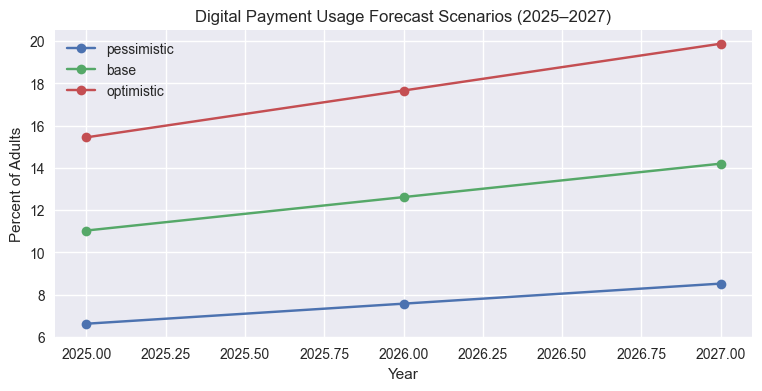

In [12]:
plt.figure(figsize=(9, 4))

for scenario in forecast_df["scenario"].unique():
    subset = forecast_df[forecast_df["scenario"] == scenario]
    plt.plot(subset["year"], subset["usage_forecast"], marker="o", label=scenario)

plt.title("Digital Payment Usage Forecast Scenarios (2025–2027)")
plt.xlabel("Year")
plt.ylabel("Percent of Adults")
plt.legend()
plt.grid(True)
plt.show()


The baseline forecast assumes historical trends continue unchanged into 2025–2027.

In [13]:
access_pred[["mean_ci_lower", "mean_ci_upper"]]
usage_pred[["mean_ci_lower", "mean_ci_upper"]]


,mean_ci_lower,mean_ci_upper
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN


Confidence intervals are not available due to limited degrees of freedom. Scenario ranges are used to represent uncertainty.

In [15]:
forecast_df.to_csv(
    "../data/processed/forecast_results.csv",
    index=False
)
